# IEOR 242 Final Project
Classify MDA sections of 10-K reports with various methods.

In [1]:
import pandas as pd
import numpy as np
import pickle
import gc
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.classify import MaxentClassifier

from classifier_evaluation import evaluate_classifier, show_most_informative_features
from clean_helper import stem_words

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
# Standard number of features
MAX_FEATURES = 1000

# Path to the Pickle file
PICKLE_FILE = 'reports_april_25_project.pickle'

# Path to the Loughran McDonald dictionary
MASTER_DICT_PATH = '../lecture/LoughranMcDonald_MasterDictionary_2014.xlsx'

## Data Loading
Read the dataframe with file contents and labels from a Pickle file.

In [3]:
with open(PICKLE_FILE, 'rb') as f:
    class_df = pickle.load(f)

print('Number of reports: %d' % len(class_df))
class_df.head()

Number of reports: 4068


,content,cik,year,quarter,subsector,name,tic,SALES_value,OIADP,AT,CEQ,SALES,INTAN,ROE,OIADP_change,AT_change,CEQ_change,SALES_change,INTAN_change,ROE_change
0,Item Management s Discussion and Analysis of ...,855654.0,2012.0,3.0,35201010.0,IMMUNOGEN INC,IMGN,3.252,pos,neg,neg,neg,NA,pos,19.308,-8.160,-16.883,-9.225,0.000,43.542
1,The following discussion and analysis provide...,788920.0,2011.0,3.0,35101010.0,PRO-DEX INC/CO,PDEX,6.876,neg,pos,pos,neg,NA,neg,-14.519,6.611,11.238,-1.891,0.000,-23.155
2,Item Managements Discussion and Analysis of...,795551.0,2011.0,1.0,35101010.0,THERAGENICS CORP,TGX,20.253,pos,pos,pos,pos,neg,pos,50.771,1.415,1.731,6.335,-6.162,48.205
3,Managements Discussion and Analysis of Financ...,352915.0,2012.0,1.0,35102020.0,UNIVERSAL HEALTH SVCS INC,UHS,1755.536,neg,neg,pos,neg,neg,neg,-4.086,-0.316,4.514,-1.882,-0.727,-8.229
4,Item Managements Discussion and Analysis of...,1027915.0,2010.0,1.0,NaN,None,None,14.887,pos,pos,pos,pos,neg,neg,16.123,3.150,16.311,5.018,-0.296,-0.162


In [4]:
# Reduce data set for faster model development
# class_df = class_df.sample(frac=0.1).reset_index(drop=True)
print('Number of reports: %d' % len(class_df))

Number of reports: 4068


In [5]:
# Replace subsector codes with subsector names
subsector_list = ['Biotechnology', 'Health Care Equipment', 'Pharmaceuticals', 'Health Care Services',
                  'Health Care Supplies', 'Life Sciences Tools & Services', 'Health Care Technology',
                  'Health Care Facilities', 'Health Care Distributors', 'Managed Health Care']
class_df['Subsector Name'] = np.nan
class_df['Subsector Name'].categories = subsector_list
class_df.loc[class_df['subsector'] == 35201010.0, 'Subsector Name'] = 'Biotechnology'
class_df.loc[class_df['subsector'] == 35101010.0, 'Subsector Name'] = 'Health Care Equipment'
class_df.loc[class_df['subsector'] == 35202010.0, 'Subsector Name'] = 'Pharmaceuticals'
class_df.loc[class_df['subsector'] == 35102015.0, 'Subsector Name'] = 'Health Care Services'
class_df.loc[class_df['subsector'] == 35101020.0, 'Subsector Name'] = 'Health Care Supplies'
class_df.loc[class_df['subsector'] == 35203010.0, 'Subsector Name'] = 'Life Sciences Tools & Services'
class_df.loc[class_df['subsector'] == 35103010.0, 'Subsector Name'] = 'Health Care Technology'
class_df.loc[class_df['subsector'] == 35102020.0, 'Subsector Name'] = 'Health Care Facilities'
class_df.loc[class_df['subsector'] == 35102010.0, 'Subsector Name'] = 'Health Care Distributors'
class_df.loc[class_df['subsector'] == 35102030.0, 'Subsector Name'] = 'Managed Health Care'
class_df.head()

,content,cik,year,quarter,subsector,name,tic,SALES_value,OIADP,AT,...,SALES,INTAN,ROE,OIADP_change,AT_change,CEQ_change,SALES_change,INTAN_change,ROE_change,Subsector Name
0,Item Management s Discussion and Analysis of ...,855654.0,2012.0,3.0,35201010.0,IMMUNOGEN INC,IMGN,3.252,pos,neg,...,neg,NA,pos,19.308,-8.160,-16.883,-9.225,0.000,43.542,Biotechnology
1,The following discussion and analysis provide...,788920.0,2011.0,3.0,35101010.0,PRO-DEX INC/CO,PDEX,6.876,neg,pos,...,neg,NA,neg,-14.519,6.611,11.238,-1.891,0.000,-23.155,Health Care Equipment
2,Item Managements Discussion and Analysis of...,795551.0,2011.0,1.0,35101010.0,THERAGENICS CORP,TGX,20.253,pos,pos,...,pos,neg,pos,50.771,1.415,1.731,6.335,-6.162,48.205,Health Care Equipment
3,Managements Discussion and Analysis of Financ...,352915.0,2012.0,1.0,35102020.0,UNIVERSAL HEALTH SVCS INC,UHS,1755.536,neg,neg,...,neg,neg,neg,-4.086,-0.316,4.514,-1.882,-0.727,-8.229,Health Care Facilities
4,Item Managements Discussion and Analysis of...,1027915.0,2010.0,1.0,NaN,None,None,14.887,pos,pos,...,pos,neg,neg,16.123,3.150,16.311,5.018,-0.296,-0.162,NaN


## Feature Building

In [6]:
# Bag of Words
count_vec = CountVectorizer(analyzer='word', stop_words='english', max_features=MAX_FEATURES)
# Bag of Words with reduced number of features
count_vec_red_feat = CountVectorizer(analyzer='word', stop_words='english', max_features=100)
# Bag of Words with 2-grams
count_vec_2grams = CountVectorizer(analyzer='word', ngram_range=(1, 2), max_features=MAX_FEATURES)
# tf-idf
tfidf_vec = TfidfVectorizer(analyzer='word', stop_words='english', max_features=MAX_FEATURES)
# tf-idf with reduced number of features
tfidf_vec_red_feat = TfidfVectorizer(analyzer='word', stop_words='english', max_features=100)
# tf-idf with 2-grams
tfidf_vec_2grams = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), max_features=MAX_FEATURES)

## Calculate Sentiment with Finance Dictionary
Loughran-McDonalds dictionary source: http://www3.nd.edu/~mcdonald/Word_Lists.html

In [7]:
# Create vectorizer to calculate word count
count_matrix = count_vec.fit_transform(class_df['content'])
feature_names = count_vec.get_feature_names()
count_df = pd.DataFrame(count_matrix.toarray())
count_df.columns = [i.upper() for i in feature_names]
count_df.head()

,ABILITY,ABLE,ACCEPTED,ACCESS,ACCOMPANYING,ACCORDANCE,ACCORDINGLY,ACCOUNT,ACCOUNTED,ACCOUNTING,...,WORKING,WORLDWIDE,WRITE,WWW,XA,XBRL,XM,YEAR,YEARS,ZEQ
0,0,0,1,0,0,2,6,1,3,18,...,1,0,2,0,0,0,0,92,31,16
1,2,1,1,0,1,1,1,1,1,8,...,3,0,2,0,0,0,0,14,4,0
2,22,5,3,3,1,7,14,2,0,13,...,2,1,2,0,0,0,0,26,15,0
3,17,1,1,3,2,4,0,5,5,9,...,0,0,10,0,0,0,0,78,41,0
4,3,1,1,1,0,1,0,10,4,17,...,2,0,1,15,0,0,0,96,22,0


In [8]:
# Loading the dictionary
dict = pd.read_excel(MASTER_DICT_PATH)

# Create a smaller dictionary that only contains the words which are used in the reports
minidict = dict[dict['Word'].isin(count_df.columns)]
minidict = minidict.set_index('Word')

# Clean the positive & negative columns
minidict.loc[minidict['Positive'] > 0, 'Positive'] = 1
minidict.loc[minidict['Negative'] > 0, 'Negative'] = -1
minidict.head()

,Sequence Number,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Constraining,Superfluous,Interesting,Modal,Irr_Verb,Harvard_IV,Syllables,Source
Word,,,,,,,,,,,,,,,,,,
ABILITY,101,8083865,0.000568,0.000600,0.000541,754403,0,0,0,0,0,0,0,0,0,0,4,12of12inf
ABLE,126,3253260,0.000229,0.000232,0.000343,553588,0,1,0,0,0,0,0,0,0,0,2,12of12inf
ACCEPTED,412,4093060,0.000288,0.000434,0.000434,802933,0,0,0,0,0,0,0,0,0,0,3,12of12inf
ACCESS,416,2312440,0.000162,0.000132,0.000750,407688,0,0,0,0,0,0,0,0,0,0,2,12of12inf
ACCOMPANYING,472,5027940,0.000353,0.000707,0.000863,824658,0,0,0,0,0,0,0,0,0,0,5,12of12inf


In [9]:
# Just some transformations to facilitate merging
count_df = count_df.T 
count_df.index.name = 'Word'

# Merge the dictionary with the report dataframe
senti_df = pd.merge(count_df, minidict, how='inner', left_index=True, right_index=True)
print('Number of rows: %d' % len(senti_df))
senti_df.head()

Number of rows: 932


,0,1,2,3,4,5,6,7,8,9,...,Uncertainty,Litigious,Constraining,Superfluous,Interesting,Modal,Irr_Verb,Harvard_IV,Syllables,Source
Word,,,,,,,,,,,,,,,,,,,,,
ABILITY,0,2,22,17,3,5,3,0,6,2,...,0,0,0,0,0,0,0,0,4,12of12inf
ABLE,0,1,5,1,1,0,0,0,0,7,...,0,0,0,0,0,0,0,0,2,12of12inf
ACCEPTED,1,1,3,1,1,1,4,0,1,1,...,0,0,0,0,0,0,0,0,3,12of12inf
ACCESS,0,0,3,3,1,0,0,0,3,2,...,0,0,0,0,0,0,0,0,2,12of12inf
ACCOMPANYING,0,1,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,12of12inf


In [10]:
# Calculate sentiments for each report and add it to the classification and report dataframe
for i, row in class_df.iterrows():
    class_df.loc[i, 'senti_pos'] = sum(senti_df[i] * senti_df['Positive'])
    class_df.loc[i, 'senti_neg'] = sum(senti_df[i] * senti_df['Negative'])
    class_df.loc[i, 'pos_word_count'] = sum(senti_df.loc[senti_df[i] > 1, 'Positive'])
    class_df.loc[i, 'neg_word_count'] = sum(senti_df.loc[senti_df[i] > 1, 'Negative'])
class_df.head()

,content,cik,year,quarter,subsector,name,tic,SALES_value,OIADP,AT,...,AT_change,CEQ_change,SALES_change,INTAN_change,ROE_change,Subsector Name,senti_pos,senti_neg,pos_word_count,neg_word_count
0,Item Management s Discussion and Analysis of ...,855654.0,2012.0,3.0,35201010.0,IMMUNOGEN INC,IMGN,3.252,pos,neg,...,-8.160,-16.883,-9.225,0.000,43.542,Biotechnology,83.0,-23.0,13.0,-7.0
1,The following discussion and analysis provide...,788920.0,2011.0,3.0,35101010.0,PRO-DEX INC/CO,PDEX,6.876,neg,pos,...,6.611,11.238,-1.891,0.000,-23.155,Health Care Equipment,11.0,-17.0,3.0,-5.0
2,Item Managements Discussion and Analysis of...,795551.0,2011.0,1.0,35101010.0,THERAGENICS CORP,TGX,20.253,pos,pos,...,1.415,1.731,6.335,-6.162,48.205,Health Care Equipment,57.0,-166.0,8.0,-15.0
3,Managements Discussion and Analysis of Financ...,352915.0,2012.0,1.0,35102020.0,UNIVERSAL HEALTH SVCS INC,UHS,1755.536,neg,neg,...,-0.316,4.514,-1.882,-0.727,-8.229,Health Care Facilities,102.0,-143.0,9.0,-11.0
4,Item Managements Discussion and Analysis of...,1027915.0,2010.0,1.0,NaN,None,None,14.887,pos,pos,...,3.150,16.311,5.018,-0.296,-0.162,NaN,24.0,-10.0,5.0,-2.0


In [11]:
class_df.describe()

,cik,year,quarter,subsector,SALES_value,OIADP_change,AT_change,CEQ_change,SALES_change,INTAN_change,ROE_change,senti_pos,senti_neg,pos_word_count,neg_word_count
count,4.068000e+03,4068.000000,4068.000000,3.583000e+03,4068.000000,4068.000000,4068.000000,4068.000000,4068.000000,4068.000000,4068.000000,4068.000000,4068.000000,4068.000000,4068.000000
mean,1.019478e+06,2012.167158,1.490905,3.515534e+07,457.334571,1.209273,26.510061,-19.954726,190.644692,109.288851,41.550163,38.394051,-55.104966,6.444690,-7.558014
std,3.390691e+05,1.575908,0.906858,4.983514e+04,2460.057294,666.436317,427.742330,1387.736301,7929.760688,3708.926563,2483.962180,56.122191,61.519450,3.962405,3.988960
min,1.800000e+03,2009.000000,1.000000,3.510101e+07,-3.007000,-24286.667000,-100.000000,-65266.667000,-219.744000,-100.000000,-28508.339000,0.000000,-2093.000000,0.000000,-21.000000
25%,8.748660e+05,2011.000000,1.000000,3.510102e+07,0.110000,-19.680250,-7.953000,-10.320500,-1.101750,-1.390750,-20.748750,16.000000,-70.000000,4.000000,-10.000000
50%,1.059790e+06,2012.000000,1.000000,3.520101e+07,5.471500,1.010500,-0.012500,0.008500,0.531000,0.000000,0.000000,30.000000,-41.000000,6.000000,-7.000000
75%,1.275538e+06,2014.000000,2.000000,3.520101e+07,68.305500,24.640000,4.251000,6.049500,9.404500,0.000000,20.161750,50.000000,-23.000000,9.000000,-5.000000
max,1.608638e+06,2015.000000,4.000000,3.520301e+07,44758.000000,7592.308000,20100.000000,19633.333000,499900.000000,171080.000000,144705.054000,2739.000000,0.000000,22.000000,0.000000


## Classifier Evaluation

### Test Multiple Labels & Classifiers

In [12]:
# Store F1 values for multiple labels
f1_score_df = pd.DataFrame()
f1_score_df.columns.name = 'Label'
f1_score_df.index.name = 'Classifier'

# Store accuracy for multiple labels
acc_score_df = pd.DataFrame()
acc_score_df.columns.name = 'Label'
acc_score_df.index.name = 'Classifier'

# List vectorizations to evaluate 
vecs = { 'BoW': count_vec, 'BoW Reduced': count_vec_red_feat,
         'BoW Bigrams': count_vec_2grams, 'tf-idf': tfidf_vec,
         'tf-idf Reduced': tfidf_vec_red_feat, 'tf-idf Bigrams': tfidf_vec_2grams }

# Prepare classifier
classifier = MultinomialNB(fit_prior=False)

In [20]:
# Calculate every vectorization and label combination
for label in ['OIADP', 'SALES', 'AT', 'CEQ', 'ROE', 'INTAN']:
    for vec_name, vec in vecs.items():
        print('Classifying %s with %s' % (label, vec_name))
        # Build matrix with reports and features
        try:
            sub_df = class_df[(class_df[label] == 'pos') | (class_df[label] == 'neg')]
            # print(sub_df.shape)
            matrix = vec.fit_transform(sub_df['content'])
        except ValueError as e:
            print(class_df[label].head())
            print(sub_df['content'].head())
        
        # Train and evaulate classifier
        metrics = evaluate_classifier(classifier, matrix, sub_df[label], 5)[1]
        acc_score_df.loc[vec_name, label] = metrics['Accuracy']
        f1_score_df.loc[vec_name, label] = metrics['F1 Score']

        # Free up memory
        sub_df = None
        matrix = None
        gc.collect()
        
    # Perform tf-idf with stemming
    vec_name = 'tf-idf Stemming'
    print('Classifying %s with %s' % (label, vec_name))
    sub_df = class_df.loc[(class_df[label] == 'pos') | (class_df[label] == 'neg')]
    matrix = vec.fit_transform(sub_df['content'].map(lambda c: stem_words(c)).tolist())
    metrics = evaluate_classifier(classifier, matrix, sub_df[label], 5)[1]
    acc_score_df.loc[vec_name, label] = metrics['Accuracy']
    f1_score_df.loc[vec_name, label] = metrics['F1 Score']
    
    # Perform maximum entropy classifier
    

Classifying OIADP with BoW Reduced
Classifying OIADP with tf-idf
Classifying OIADP with BoW
Classifying OIADP with BoW Bigrams
Classifying OIADP with tf-idf Reduced
Classifying OIADP with tf-idf Bigrams
Classifying OIADP with tf-idf Stemming
Classifying SALES with BoW Reduced
Classifying SALES with tf-idf
Classifying SALES with BoW
Classifying SALES with BoW Bigrams
Classifying SALES with tf-idf Reduced
Classifying SALES with tf-idf Bigrams
Classifying SALES with tf-idf Stemming
Classifying AT with BoW Reduced
Classifying AT with tf-idf
Classifying AT with BoW
Classifying AT with BoW Bigrams
Classifying AT with tf-idf Reduced
Classifying AT with tf-idf Bigrams
Classifying AT with tf-idf Stemming
Classifying CEQ with BoW Reduced
Classifying CEQ with tf-idf
Classifying CEQ with BoW
Classifying CEQ with BoW Bigrams
Classifying CEQ with tf-idf Reduced
Classifying CEQ with tf-idf Bigrams
Classifying CEQ with tf-idf Stemming
Classifying ROE with BoW Reduced
Classifying ROE with tf-idf
Classi

In [21]:
acc_score_df.sort_index(inplace=True)
acc_score_df

Label,OIADP,SALES,CEQ,ROE,AT,INTAN
Classifier,,,,,,
BoW,0.470843,0.375622,0.484003,0.500000,0.523746,0.646959
BoW Bigrams,0.471161,0.363435,0.480444,0.499276,0.522704,0.648800
BoW Reduced,0.470576,0.363083,0.480544,0.499464,0.522273,0.647272
tf-idf,0.564484,0.618271,0.629699,0.583062,0.635479,0.642523
tf-idf Bigrams,0.557842,0.614750,0.628999,0.559045,0.637625,0.669205
tf-idf Reduced,0.551177,0.604392,0.629970,0.540590,0.626498,0.579112
tf-idf Stemming,0.557350,0.614798,0.629308,0.558318,0.637746,0.669719


In [22]:
f1_score_df.sort_index(inplace=True)
f1_score_df

Label,OIADP,SALES,CEQ,ROE,AT,INTAN
Classifier,,,,,,
BoW,0.019811,0.115359,0.030722,0.022157,0.024144,0.023394
BoW Bigrams,0.019832,0.067411,0.014546,0.016083,0.017927,0.023519
BoW Reduced,0.018884,0.074868,0.016459,0.019739,0.018927,0.021382
tf-idf,0.554169,0.692319,0.645685,0.582089,0.625801,0.514162
tf-idf Bigrams,0.538150,0.690639,0.645019,0.561282,0.624529,0.395897
tf-idf Reduced,0.544088,0.676428,0.653257,0.564028,0.627471,0.487489
tf-idf Stemming,0.537639,0.690701,0.645303,0.559538,0.624715,0.396743


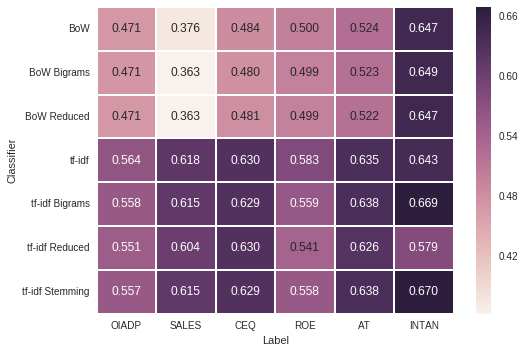

In [23]:
# Plot heat map for accuracy
sns.heatmap(acc_score_df, annot=True, fmt='.3f', linewidths=1)

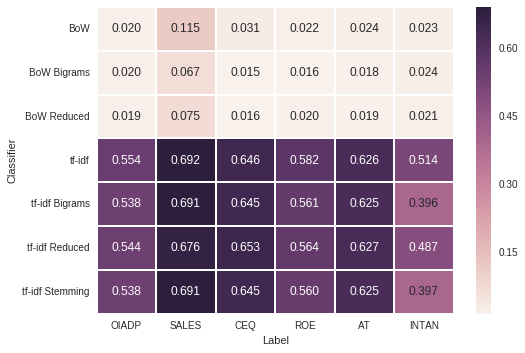

In [24]:
# Plot heat map for F1 Score
sns.heatmap(f1_score_df, annot=True, fmt='.3f', linewidths=1)

### Baseline

In [25]:
intan_df = class_df.loc[(class_df['INTAN'] == 'pos') | (class_df['INTAN'] == 'neg')]

In [45]:
print(len(intan_df[intan_df['INTAN'] == 'pos']))
print(len(intan_df[intan_df['INTAN'] == 'neg']))

919
1691


In [48]:
from sklearn.metrics import accuracy_score
y_true = np.empty(len(intan_df))
y_true.fill(False)
y_pred = (intan_df['INTAN'] == 'pos')
accuracy_score(y_true, y_pred)

0.64789272030651346

### Bag of Words - Optimize Number of Features

In [27]:
eval_df = pd.DataFrame(columns=['Max Feature'])

classifier = MultinomialNB(fit_prior=False)

for i in [10, 50, 100, 500, 1000, 5000, 10000]:
    print('Classifying with %d features.' % i)
    tfidf_vec = TfidfVectorizer(analyzer='word', stop_words='english', max_features=i)
    tfidf_matrix = tfidf_vec.fit_transform(intan_df['content'])
    tfidf_eval = evaluate_classifier(classifier, tfidf_matrix, intan_df['INTAN'], 5)
    result = pd.DataFrame(tfidf_eval[1], index=[0])
    result['Max Feature'] = i
    eval_df = eval_df.append(result)

eval_df

Classifying with 10 features.
Classifying with 50 features.
Classifying with 100 features.
Classifying with 500 features.
Classifying with 1000 features.
Classifying with 5000 features.
Classifying with 10000 features.


,Accuracy,F1 Score,Max Feature,Precision,Recall
0,0.560250,0.307524,10.0,0.346344,0.276535
0,0.570430,0.486644,50.0,0.420726,0.577057
0,0.579586,0.487849,100.0,0.427892,0.567345
0,0.624520,0.491469,500.0,0.470613,0.514261
0,0.642344,0.513853,1000.0,0.493878,0.535513
0,0.733644,0.520006,5000.0,0.714519,0.408737
0,0.714911,0.352470,10000.0,0.887533,0.219900


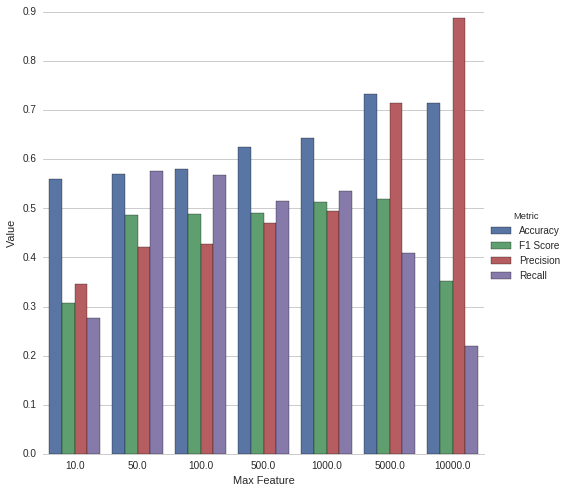

In [28]:
bar_chart_prep = pd.melt(eval_df, id_vars=['Max Feature'],
                         value_vars=['Accuracy', 'F1 Score', 'Precision', 'Recall'],
                         var_name='Metric', value_name='Value')

g = sns.factorplot(x='Max Feature', y='Value', hue='Metric', data=bar_chart_prep, size=7, kind='bar')
g.despine(left=True)
g.set_ylabels('Value')

### Bag of Words - Optimize n-grams

In [29]:
ngram_eval_df = pd.DataFrame(columns=['n'])

classifier = MultinomialNB(fit_prior=False)

for n in [1, 2, 3]:
    print('Classifying with (1,%d)-grams.' % n)
    tfidf_vec = TfidfVectorizer(analyzer='word', max_features=MAX_FEATURES, ngram_range=(1,n))
    tfidf_matrix = tfidf_vec.fit_transform(intan_df['content'])
    result = pd.DataFrame(evaluate_classifier(classifier, tfidf_matrix, intan_df['INTAN'], 5)[1], index=[0])
    result['n'] = n
    ngram_eval_df = ngram_eval_df.append(result)

    # Free up memory
    tfidf_vec = None
    tfidf_matrix = None
    gc.collect()

ngram_eval_df

Classifying with (1,1)-grams.
Classifying with (1,2)-grams.
Classifying with (1,3)-grams.


,Accuracy,F1 Score,Precision,Recall,n
0,0.669587,0.435753,0.548217,0.361577,1.0
0,0.669281,0.396296,0.557223,0.307492,2.0
0,0.668974,0.335184,0.575294,0.236485,3.0


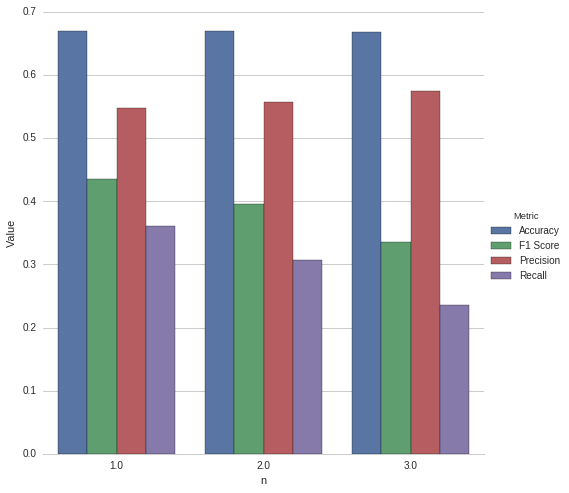

In [30]:
bar_chart_prep = pd.melt(ngram_eval_df, id_vars=['n'],
                         value_vars=['Accuracy', 'F1 Score', 'Precision', 'Recall'],
                         var_name='Metric', value_name='Value')

g = sns.factorplot(x='n', y='Value', hue='Metric', data=bar_chart_prep, size=7, kind='bar')
g.despine(left=True)
g.set_ylabels('Value')

### Sentiment development over time

In [31]:
class_df['total_sentiment'] = class_df['senti_pos'] + class_df['senti_neg']
class_df.head()

,content,cik,year,quarter,subsector,name,tic,SALES_value,OIADP,AT,...,CEQ_change,SALES_change,INTAN_change,ROE_change,Subsector Name,senti_pos,senti_neg,pos_word_count,neg_word_count,total_sentiment
0,Item Management s Discussion and Analysis of ...,855654.0,2012.0,3.0,35201010.0,IMMUNOGEN INC,IMGN,3.252,pos,neg,...,-16.883,-9.225,0.000,43.542,Biotechnology,83.0,-23.0,13.0,-7.0,60.0
1,The following discussion and analysis provide...,788920.0,2011.0,3.0,35101010.0,PRO-DEX INC/CO,PDEX,6.876,neg,pos,...,11.238,-1.891,0.000,-23.155,Health Care Equipment,11.0,-17.0,3.0,-5.0,-6.0
2,Item Managements Discussion and Analysis of...,795551.0,2011.0,1.0,35101010.0,THERAGENICS CORP,TGX,20.253,pos,pos,...,1.731,6.335,-6.162,48.205,Health Care Equipment,57.0,-166.0,8.0,-15.0,-109.0
3,Managements Discussion and Analysis of Financ...,352915.0,2012.0,1.0,35102020.0,UNIVERSAL HEALTH SVCS INC,UHS,1755.536,neg,neg,...,4.514,-1.882,-0.727,-8.229,Health Care Facilities,102.0,-143.0,9.0,-11.0,-41.0
4,Item Managements Discussion and Analysis of...,1027915.0,2010.0,1.0,NaN,None,None,14.887,pos,pos,...,16.311,5.018,-0.296,-0.162,NaN,24.0,-10.0,5.0,-2.0,14.0


In [42]:
senti_ts = class_df[['year', 'Subsector Name', 'total_sentiment']]
senti_ts['count'] = 1
senti_ts = senti_ts.groupby(['year', 'Subsector Name']).sum().reset_index()
print(senti_ts)

      year                  Subsector Name  total_sentiment  count
0   2009.0                   Biotechnology            -26.0      4
1   2009.0           Health Care Equipment            -96.0      5
2   2009.0            Health Care Supplies            -16.0      2
3   2009.0          Health Care Technology            -38.0      2
4   2009.0  Life Sciences Tools & Services            -10.0      1
5   2009.0                 Pharmaceuticals             -1.0      4
6   2010.0                   Biotechnology           -129.0    227
7   2010.0        Health Care Distributors           -455.0     16
8   2010.0           Health Care Equipment          -3806.0    139
9   2010.0          Health Care Facilities          -2068.0     38
10  2010.0            Health Care Services          -2237.0     71
11  2010.0            Health Care Supplies           -601.0     43
12  2010.0          Health Care Technology           -521.0     32
13  2010.0  Life Sciences Tools & Services           -889.0   

/home/stefan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


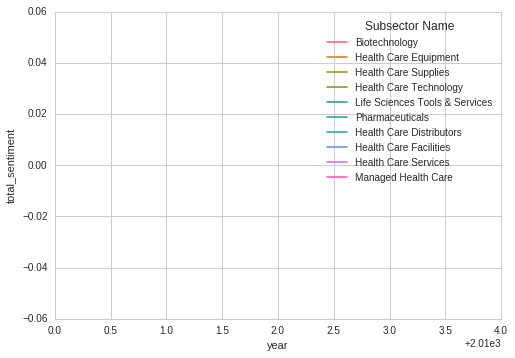

In [43]:
ax = sns.tsplot(time="year", value="total_sentiment", unit="count", condition="Subsector Name", data=senti_ts)

### Company Performance vs. Usage of Positive Words

/home/stefan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


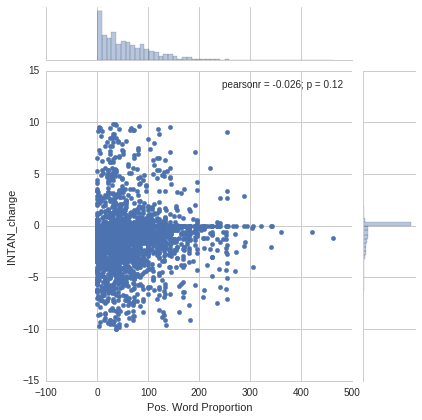

In [34]:
ceq_perf_df = class_df
ceq_perf_df['INTAN_change'] = ceq_perf_df['INTAN_change'].convert_objects(convert_numeric=True)
ceq_perf_df = ceq_perf_df[(ceq_perf_df['INTAN_change'] > -10.0) & (ceq_perf_df['INTAN_change'] < 10.0)]
ceq_perf_df = ceq_perf_df.replace([np.inf, -np.inf], np.nan)
ceq_perf_df['Pos. Word Proportion'] = ceq_perf_df['pos_word_count'] / (-1) * ceq_perf_df['neg_word_count']
ax = sns.jointplot(x='Pos. Word Proportion', y='INTAN_change', data=ceq_perf_df)

/home/stefan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


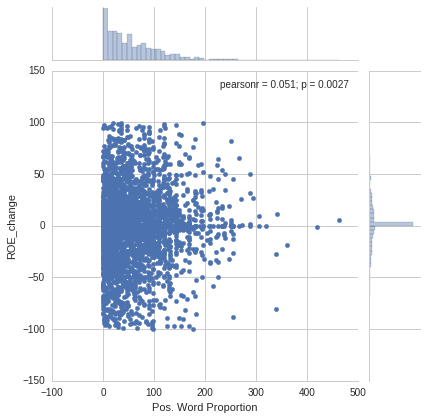

In [36]:
ceq_perf_df = class_df
ceq_perf_df['ROE_change'] = ceq_perf_df['ROE_change'].convert_objects(convert_numeric=True)
ceq_perf_df = ceq_perf_df[(ceq_perf_df['ROE_change'] > -100.0) & (ceq_perf_df['ROE_change'] < 100.0)]
ceq_perf_df = ceq_perf_df.replace([np.inf, -np.inf], np.nan)
ceq_perf_df['Pos. Word Proportion'] = ceq_perf_df['pos_word_count'] / (-1) * ceq_perf_df['neg_word_count']
ax = sns.jointplot(x='Pos. Word Proportion', y='ROE_change', data=ceq_perf_df)